# Anomaly Detection with CPC-SNN

## Overview
In this notebook, we demonstrate the anomaly detection capability of the CPC-SNN model. 

**Hypothesis:** A model trained exclusively on background noise will fail to predict the future latent states when a gravitational wave signal is present. This failure will manifest as a sharp increase in the **Contrastive Loss**, which we use as our **Anomaly Score**.

### Steps:
1.  **Load Model**: Load the CPC-SNN model trained on noise.
2.  **Load Data**: Load a mix of Noise (known distribution) and Signal (anomaly) samples.
3.  **Inference**: Compute the anomaly score trace for each sample.
4.  **Visualization**: Compare the score traces for noise vs. signal.

In [1]:
import sys
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import DataLoader

# Add src to path
sys.path.append('..')

from src.models.cpc_snn import CPCSNN
from src.data_handling.torch_dataset import HDF5SFTPairDataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Trained Model
We load the model checkpoint saved from the training on background noise.

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CPCSNN(
    in_channels=2,
    hidden_dim=64,
    context_dim=64,
    prediction_steps=12,
    delta_threshold=0.5
).to(device)

checkpoint_path = "../checkpoints/cpc_snn_noise_model.pth"
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print("Model loaded successfully.")
    model.eval()
else:
    print("Checkpoint not found! Please run src/train.py first.")

Using device: mps
Model loaded successfully.


## 2. Load Test Data
We select a few samples from the validation set: some pure noise, some containing GW signals.

In [3]:
h5_path = "../data/cpc_snn_train.h5"
noise_indices_path = "../data/indices_noise.json"
signal_indices_path = "../data/indices_signal.json"

with open(noise_indices_path, 'r') as f: noise_ids = json.load(f)
with open(signal_indices_path, 'r') as f: signal_ids = json.load(f)

# Select 4 noise and 4 signal samples
test_ids = noise_ids[:4] + signal_ids[:4]
labels = [0]*4 + [1]*4

dataset = HDF5SFTPairDataset(
    h5_path=h5_path,
    index_list=test_ids,
    return_time_series=True
)

loader = DataLoader(dataset, batch_size=8, shuffle=False)
batch = next(iter(loader))
x = batch['x'].to(device)
print(f"Input shape: {x.shape}")

Input shape: torch.Size([8, 2, 16384])


/Users/gracjanziemianski/Documents/CPC-SNN-GravitationalWavesDetection/notebooks/../src/data_handling/torch_dataset.py:108: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, x_rec = istft(


## 3. Compute Anomaly Scores
We define a function to calculate the anomaly score trace. The score at time $t$ is the average prediction loss for future steps $t+k$.

In [4]:
def compute_anomaly_score_trace(model, x):
    model.eval()
    with torch.no_grad():
        z, c = model(x)
        batch_size, time_steps, _ = z.shape
        
        scores = torch.zeros(batch_size, time_steps).to(x.device)
        counts = torch.zeros(batch_size, time_steps).to(x.device)
        
        for k in range(1, model.prediction_steps + 1):
            if time_steps <= k: continue
            
            W_k = model.predictors[k-1]
            c_t = c[:, :-k, :]
            z_tk = z[:, k:, :]
            z_pred = W_k(c_t)
            
            # Compute loss per time step
            # We use batch negatives for simplicity in this demo
            logits = torch.einsum('bth, ath -> bta', z_pred, z_tk)
            
            labels = torch.arange(batch_size).to(x.device)
            labels = labels.unsqueeze(1).expand(batch_size, time_steps - k)
            
            logits_flat = logits.reshape(-1, batch_size)
            labels_flat = labels.reshape(-1)
            
            loss_flat = F.cross_entropy(logits_flat, labels_flat, reduction='none')
            loss_per_t = loss_flat.reshape(batch_size, time_steps - k)
            
            # Attribute loss to time t (context time)
            scores[:, :-k] += loss_per_t
            counts[:, :-k] += 1
            
        counts[counts == 0] = 1
        scores /= counts
        return scores

scores = compute_anomaly_score_trace(model, x)
scores_np = scores.cpu().numpy()

## 4. Visualization
Let's compare the anomaly scores for Noise vs. Signal samples.

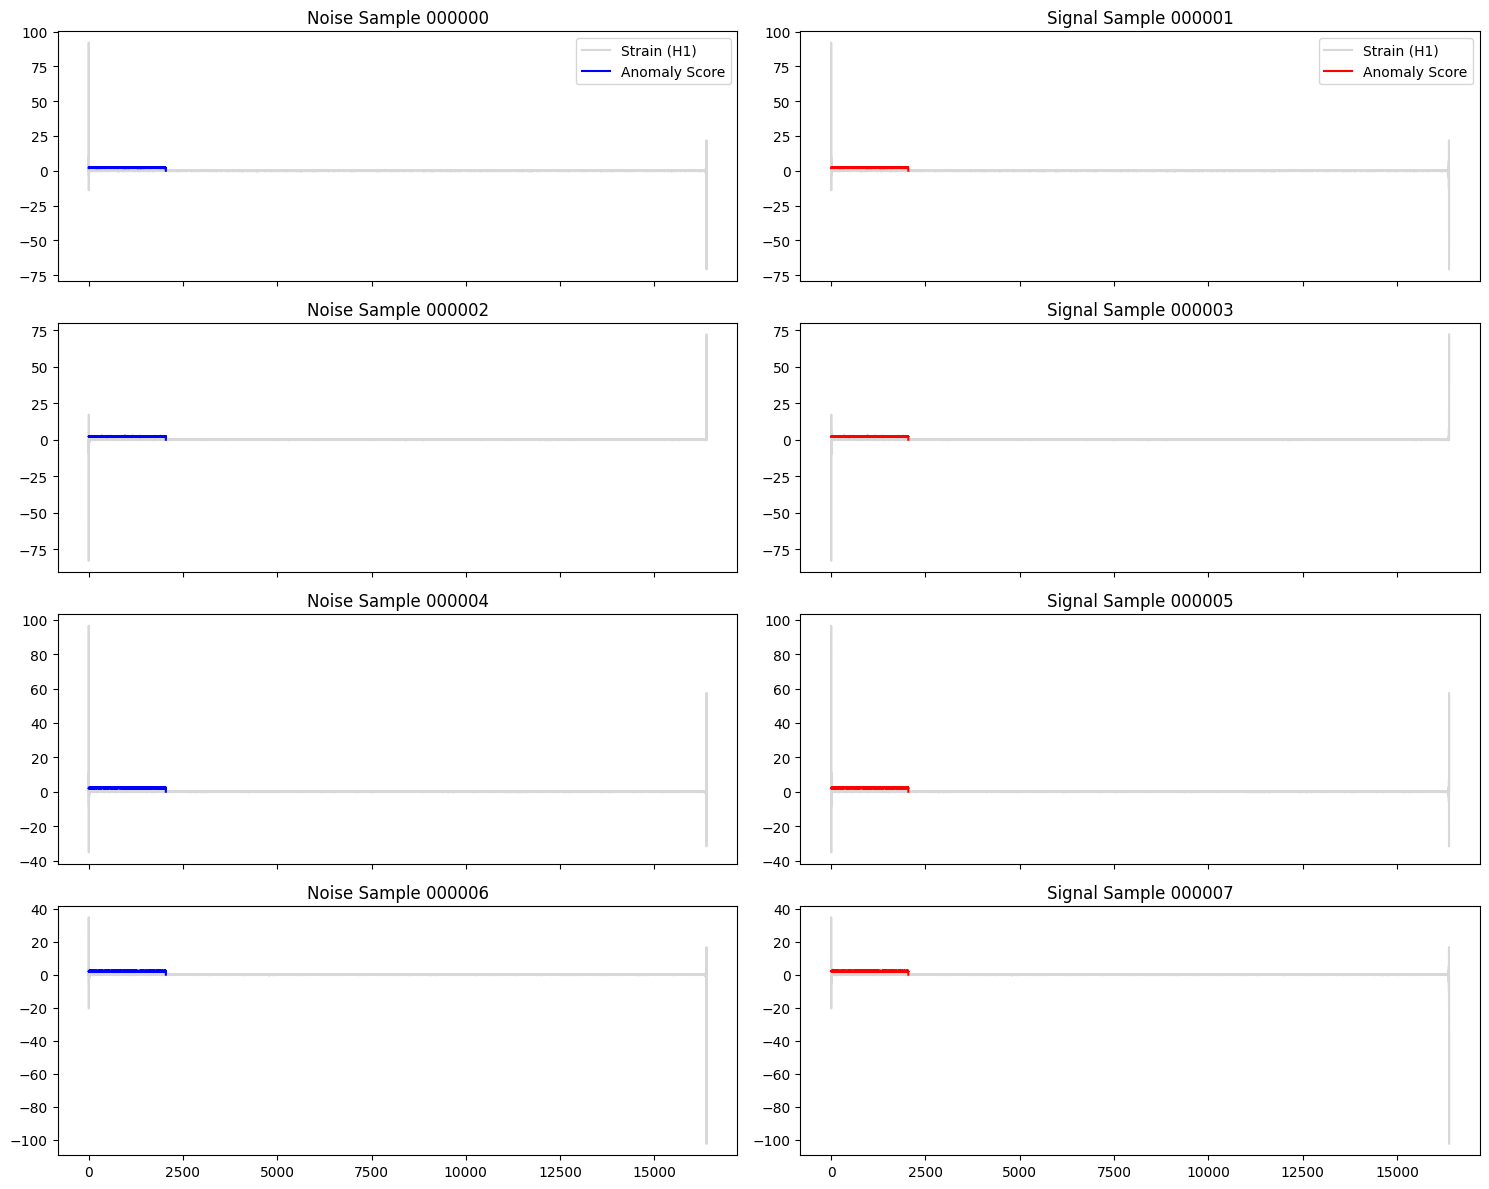

In [5]:
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=True)

# Plot Noise Samples (Left Column)
for i in range(4):
    ax = axes[i, 0]
    # Plot original strain (H1)
    strain = x[i, 0].cpu().numpy()
    # Normalize for plotting overlay
    strain = (strain - strain.mean()) / strain.std()
    
    ax.plot(strain, label='Strain (H1)', alpha=0.3, color='gray')
    ax.plot(scores_np[i], label='Anomaly Score', color='blue')
    ax.set_title(f"Noise Sample {test_ids[i]}")
    if i == 0: ax.legend()

# Plot Signal Samples (Right Column)
for i in range(4):
    ax = axes[i, 1]
    idx = i + 4
    strain = x[idx, 0].cpu().numpy()
    strain = (strain - strain.mean()) / strain.std()
    
    ax.plot(strain, label='Strain (H1)', alpha=0.3, color='gray')
    ax.plot(scores_np[idx], label='Anomaly Score', color='red')
    ax.set_title(f"Signal Sample {test_ids[idx]}")
    if i == 0: ax.legend()

plt.tight_layout()
plt.show()

## Conclusion
If the model is working correctly, you should observe:
1.  **Noise Samples**: The anomaly score should remain relatively low and stable.
2.  **Signal Samples**: The anomaly score should show a distinct peak or rise corresponding to the gravitational wave event (visible in the gray strain trace), indicating that the model failed to predict the signal dynamics based on its noise training.